In [136]:
import abc
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import patches
from torchvision import transforms
from tqdm import tqdm
from operators import Operator, BlurOperator
import torch
from torch import nn, Tensor
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from dataset.FastPatchExtractor import FastPatchExtractor, FastImageLoader
from kernels import gaussian_kernel_generator
from regularisers import Regulariser, PatchNrRegulariser

ImportError: cannot import name 'Operator' from 'operators' (/home/jupyter/nf-for-inv-problems/operators/__init__.py)

In [134]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


In [135]:
patch_size = 6

In [31]:
# This code belongs to the paper
#
# F. Altekrüger, A. Denker, P. Hagemann, J. Hertrich, P. Maass and G. Steidl (2023).
# PatchNR: Learning from Very Few Images by Patch Normalizing Flow Regularization.
# Inverse Problems, vol. 39, no. 6.

def create_NF(num_layers = 5, sub_net_size = 512, dimension=patch_size**2):
    """
    Creates the patchNR network
    """
    def subnet_fc(c_in, c_out):
        return nn.Sequential(nn.Linear(c_in, sub_net_size), nn.ReLU(),
                             nn.Linear(sub_net_size, sub_net_size), nn.ReLU(),
                             nn.Linear(sub_net_size,  c_out))
    nodes = [Ff.InputNode(dimension, name='input')]
    for k in range(num_layers):
        nodes.append(Ff.Node(nodes[-1],
                          Fm.GLOWCouplingBlock,
                          {'subnet_constructor':subnet_fc, 'clamp':1.6},
                          name=F'coupling_{k}'))
        nodes.append(Ff.Node(nodes[-1],
                          Fm.PermuteRandom,
                          {'seed':(k+1)},
                          name=F'permute_flow_{k}'))
    nodes.append(Ff.OutputNode(nodes[-1], name='output'))

    return Ff.ReversibleGraphNet(nodes, verbose=False).to(DEVICE)

In [120]:
def variational_model_solver(deg_img: Tensor, operator: Operator, regulariser: Regulariser, lam=0.87, steps = 600, device=DEVICE):
    degraded_image = deg_img.clone().to(device)
    reconstructed_image = torch.tensor(degraded_image.clone(), dtype=torch.float, device=device, requires_grad=True)

    optimizer = torch.optim.Adam([reconstructed_image], lr=0.005)

    step_bar = tqdm(range(steps))

    losses = []
    likelihoods = []
    regularisation = []

    for _ in step_bar:
        optimizer.zero_grad()
        reg = regulariser.evaluate(reconstructed_image)
        likelihood = torch.sum((operator(reconstructed_image) - degraded_image)**2)
        loss = likelihood + lam*reg
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        likelihoods.append(likelihood.item())
        regularisation.append(reg)
        step_bar.set_description_str(f'Loss: {loss}; Likelihood: {likelihood} R: {reg}')
    return reconstructed_image, (losses, likelihoods, regularisation)

In [121]:
def plot_image(path, img0, selected_patch=(100, 100), p_size=30):
    image0 = img0.to('cpu')
  #  image1 = img1.to('cpu')
    out_dim = (p_size, p_size)
    patch_extractor = FastPatchExtractor(p_dim=p_size, pad=True)
    c, x, y = image0.size()
    p_x, p_y = selected_patch
    p_pos = p_y*x + p_x
    p_image0 = torch.reshape(patch_extractor.extract(image0.unsqueeze(0))[p_pos], out_dim)
    fig, axes = plt.subplots(2, 1, figsize=(3,4))
    rect1 = patches.Rectangle((p_x, p_y), p_size, p_size, linewidth=1, edgecolor='r',facecolor='none')
    axes[0].imshow(image0.squeeze(), cmap='gray')
    axes[0].add_patch(rect1)
    axes[0].axis('off')
    axes[1].imshow(p_image0.squeeze(), cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()
    fig.show()
    fig.savefig(path)

In [122]:
model_weights = torch.load('patchNR/patchNR_weights/weights_material.pth', map_location=DEVICE)
model = create_NF()
model.load_state_dict(model_weights['net_state_dict'])

<All keys matched successfully>

In [123]:
patch_nr_regulariser = PatchNrRegulariser(model.to(DEVICE), p_size=patch_size, sample_number=40000, padding=True, padding_size=8, device=DEVICE)

In [124]:
gaussian_kernel = gaussian_kernel_generator(5, 1)
blur_operator = BlurOperator(gaussian_kernel, device=DEVICE)

In [125]:
#plot parameters
plot_sel_patch_pos = (325, 325)
plot_patch_size = 50

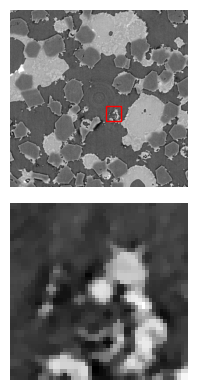

In [126]:
image_loader = FastImageLoader('data/material_pt_nr/test.png', device=DEVICE)
ground_truth = image_loader[0]
plot_image('results/deblurring/ground_truth.png', ground_truth, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

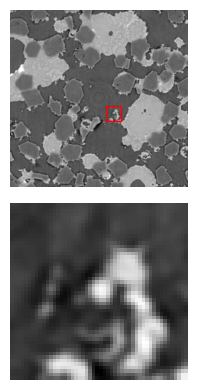

In [127]:
degraded_image = blur_operator(ground_truth)
plot_image('results/deblurring/degraded_input.png', degraded_image, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

In [128]:
reconstructed = variational_model_solver(degraded_image.to(DEVICE), blur_operator, regulariser=patch_nr_regulariser, lam=0.87)

/var/tmp/ipykernel_2514/605285162.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstructed_image = torch.tensor(degraded_image.clone(), dtype=torch.float, device=device, requires_grad=True)
Loss: 2719393024.0; Likelihood: 3879753.5 R: 271551328.0: 100%|██████████| 600/600 [02:28<00:00,  4.03it/s] 


In [129]:
img, loss_components = reconstructed

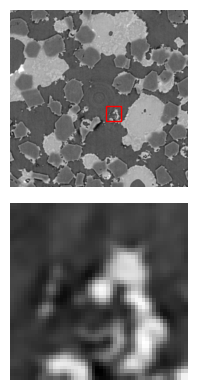

In [130]:
plot_image('results/deblurring/reconstructed.png', img.detach().cpu(), selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

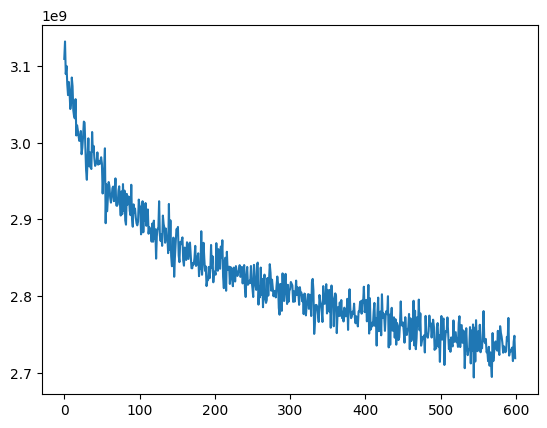

In [132]:
loss, likelihood, regularisation = loss_components
loss = torch.tensor(loss, device='cpu')
likelihood = torch.tensor(likelihood, device='cpu')
regularisation = torch.tensor(regularisation, device='cpu')

plt.plot([i for i in zip(
    loss,
  #  likelihood,
#    regularisation
)])